6.1.5 - useful intuition for activation functions and NN architecture

In [4]:
import torch
import numpy as np


In [ ]:
t_c = [0.5,14.0,15.0,28.0,11.0,8.0,3.0,-4.0,6.0,13.0,21.0]
t_u = [35.7,55.9,58.2,81.9,56.3,48.9,33.9,21.8,48.4,60.4,68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([7, 5, 4, 6, 2, 1, 3, 9, 0]), tensor([10,  8]))

In [ ]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [ ]:
val_t_un

tensor([5.8200, 2.1800])

In [ ]:
val_t_un.shape

torch.Size([2])

Note: I need to transpose the tensor to feed it into the nn.Linear(1,1) model. The number of columns corresponds to the number of features that I feed to my NN.

For torch.nn.Linear, there are three arguments:
- Number of input features
- Number of output features
- Bias (default to true)

In [ ]:
import torch.nn as nn

linear_model = nn.Linear(1,1)


In [ ]:
x = torch.ones(1)
linear_model(x)

tensor([1.1543], grad_fn=<ViewBackward0>)

Batching inputs: Each row below corresponds to one input (of one feature in this case)

In [ ]:
x = torch.ones(10,1)
linear_model(x)

tensor([[1.1543],
        [1.1543],
        [1.1543],
        [1.1543],
        [1.1543],
        [1.1543],
        [1.1543],
        [1.1543],
        [1.1543],
        [1.1543]], grad_fn=<AddmmBackward0>)

What I did before to create the t_un_val, I can do with the unsqueeze command.

In [ ]:
# t_c = torch.tensor(t_c).unsqueeze(1)
# t_u = torch.tensor(t_u).unsqueeze(1)
# t_u.shape

In [ ]:
t_un_train =  train_t_un.unsqueeze(1)
t_un_val = val_t_un.unsqueeze(1)

t_c_train = train_t_c.unsqueeze(1)
t_c_val = val_t_c.unsqueeze(1)

In [ ]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5775]], requires_grad=True),
 Parameter containing:
 tensor([0.8660], requires_grad=True)]

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
  for epoch in range(1, n_epochs+1):
    t_p_train = model(t_u_train)
    loss_train = loss_fn(t_p_train, t_c_train)

    t_p_val = model(t_u_val)
    loss_val = loss_fn(t_p_val,t_c_val)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
      f"Validation loss {loss_val.item():.4f}")


In [ ]:
import torch.optim as optim

linear_model = nn.Linear(1,1)
optimizer = optim.SGD( linear_model.parameters(), lr = 1e-2)



In [ ]:
training_loop(
    n_epochs=3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

Epoch 1, Training loss 274.4547,Validation loss 369.6840
Epoch 1000, Training loss 3.1007,Validation loss 7.6342
Epoch 2000, Training loss 2.4512,Validation loss 5.7326
Epoch 3000, Training loss 2.4377,Validation loss 5.4857


In [ ]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.2240]], requires_grad=True)
Parameter containing:
tensor([-16.4554], requires_grad=True)


# Ex. 1

In [ ]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)

In [ ]:
training_loop(
    n_epochs = 5000,
    optimizer = optim.SGD(seq_model.parameters(), lr=1e-3),
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val

)

Epoch 1, Training loss 160.3676,Validation loss 216.7280
Epoch 1000, Training loss 4.4579,Validation loss 5.0294
Epoch 2000, Training loss 3.4301,Validation loss 3.6895
Epoch 3000, Training loss 2.2220,Validation loss 2.1419
Epoch 4000, Training loss 1.9194,Validation loss 1.9353
Epoch 5000, Training loss 1.8743,Validation loss 2.0697


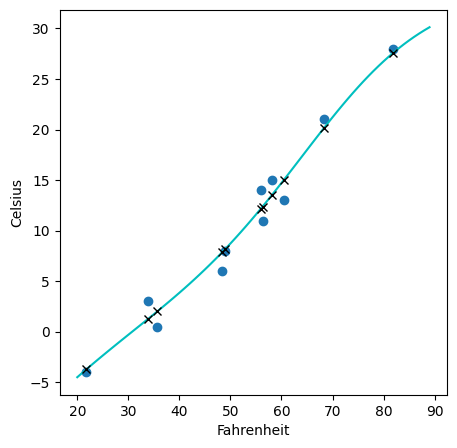

In [ ]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(figsize=(5,5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u.unsqueeze(1)).detach().numpy(), 'kx')
plt.show()

In order to get a more linear result from the sequential model, I have remove the non linear activation function.

In [ ]:
seq_model_1 = nn.Sequential(
    nn.Linear(1,13),
    nn.Linear(13,1)
)

In [ ]:
training_loop(
    n_epochs = 5000,
    optimizer = optim.SGD(seq_model_1.parameters(), lr=1e-3),
    model = seq_model_1,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val

)

Epoch 1, Training loss 267.1893,Validation loss 360.0502
Epoch 1000, Training loss 2.4507,Validation loss 5.7274
Epoch 2000, Training loss 2.4374,Validation loss 5.4452
Epoch 3000, Training loss 2.4374,Validation loss 5.4449
Epoch 4000, Training loss 2.4374,Validation loss 5.4448
Epoch 5000, Training loss 2.4374,Validation loss 5.4448


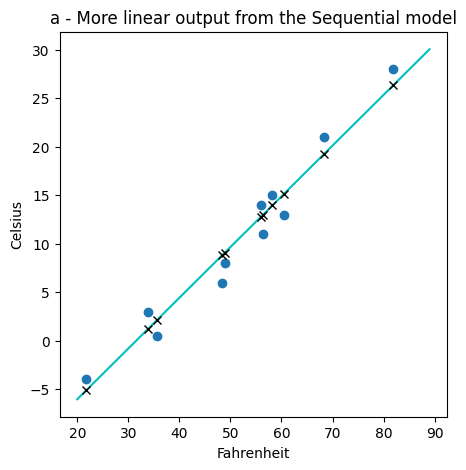

In [ ]:
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(figsize=(5,5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.title('a - More linear output from the Sequential model')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model_1(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model_1(0.1 * t_u.unsqueeze(1)).detach().numpy(), 'kx')
plt.show()

To make the model obviously overfit, I can just add extra parameters.

In [ ]:
seq_model_2 = nn.Sequential(
    nn.Linear(1,25),
    nn.Tanh(),
    nn.Linear(25,5),
    nn.Tanh(),
    nn.Linear(5,1)
)

In [ ]:
training_loop(
    n_epochs = 5000,
    optimizer = optim.SGD(seq_model_2.parameters(), lr=1e-3),
    model = seq_model_2,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val

)

Epoch 1, Training loss 188.4010,Validation loss 255.2693
Epoch 1000, Training loss 8.5619,Validation loss 11.1915
Epoch 2000, Training loss 2.8246,Validation loss 4.7506
Epoch 3000, Training loss 1.8783,Validation loss 4.0480
Epoch 4000, Training loss 1.6603,Validation loss 4.4774
Epoch 5000, Training loss 1.5803,Validation loss 4.6093


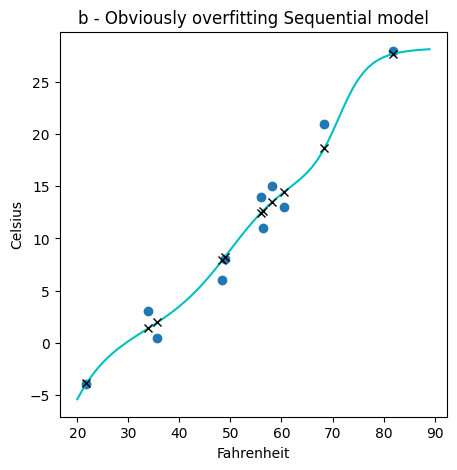

In [ ]:
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(figsize=(5,5))
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.title('b - Obviously overfitting Sequential model')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model_2(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model_2(0.1 * t_u.unsqueeze(1)).detach().numpy(), 'kx')
plt.show()

# Ex. 2

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

wine_data_path = '/content/drive/My Drive/Colab Notebooks/wine_data.csv'

# wine_data = pd.read_csv(wine_data_path, delimiter=';')
# wine_data.head()


Mounted at /content/drive


In [5]:
wine_data = np.loadtxt(wine_data_path, dtype=np.float32, delimiter=';', skiprows=1)
wine_data

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [7]:
import csv
label_list = next(csv.reader(open(wine_data_path), delimiter=';'))
label_list

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [10]:
import torch

wine_data_t = torch.from_numpy(wine_data)
wine_data_t.shape, wine_data_t.dtype

(torch.Size([4898, 12]), torch.float32)

In [12]:
# I want to separate the data from the target (wine quality)
data_t = wine_data_t[:,:-1]
data_t.shape

torch.Size([4898, 11])

In [13]:
wine_quality_t = wine_data_t[:,-1]
wine_quality_t.shape

torch.Size([4898])

In [15]:
# Break this up into training and validation data sets

n_samples = data_t.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]


In [17]:
train_data = data_t[train_indices]
val_data = data_t[val_indices]
train_data.shape, val_data.shape

(torch.Size([3919, 11]), torch.Size([979, 11]))

In [39]:
train_labels = wine_quality_t[train_indices]
val_labels = wine_quality_t[val_indices]

In [ ]:
## Normalize the inputs ??


In [40]:
import torch.nn as nn

my_model = nn.Sequential(
    nn.Linear(11,22),
    nn.Tanh(),
    nn.Linear(22,1)
)
my_model

Sequential(
  (0): Linear(in_features=11, out_features=22, bias=True)
  (1): Tanh()
  (2): Linear(in_features=22, out_features=1, bias=True)
)

In [41]:
import torch.optim as optim

optimizer = optim.Adam(my_model.parameters(),lr=1e-2)

def training_loop(n_epochs, optimizer, model, loss_fn, train_data, val_data, train_labels, val_labels):
  for epoch in range(1, n_epochs+1):
    model.train()
    y_train = model(train_data)
    loss_train = loss_fn(y_train, train_labels)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model.eval()
    y_val = model(val_data)
    loss_val = loss_fn(y_val, val_labels)



    if epoch == 1 or epoch % 1000 == 0:
      print(f'Epoch {epoch}, Taining Loss {loss_train.item():.4f},'
      f'Validation loss {loss_val.item():.4f}')








In [42]:
training_loop(n_epochs=5000,
              optimizer=optimizer,
              model = my_model,
              loss_fn = nn.MSELoss(),
              train_data = train_data,
              val_data = val_data,
              train_labels = train_labels,
              val_labels = val_labels
              )

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3919])) that is different to the input size (torch.Size([3919, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([979])) that is different to the input size (torch.Size([979, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Taining Loss 31.2674,Validation loss 28.1024
Epoch 1000, Taining Loss 0.7895,Validation loss 0.7638
Epoch 2000, Taining Loss 0.7895,Validation loss 0.7638
Epoch 3000, Taining Loss 0.7895,Validation loss 0.7638
Epoch 4000, Taining Loss 0.7895,Validation loss 0.7638
Epoch 5000, Taining Loss 0.7895,Validation loss 0.7638


Training is much slower compared to the temperature model. That is expected since we have more parameters to train and a significantly larger training and validation dataset. Probably moving things to the GPU would make it train faster.

Graphing:
- It would be useful to plot the training loss and validation loss as functions of the epoch on the same plot.
- Maybe we make a histogram of how many correct quality ratings the model gets given a specific label eg acidity (?)